In [18]:
import torch
from torch import nn

import torchvision

import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
device = "mps" if torch.backends.mps.is_available() else "cpu"
device


'mps'

In [19]:
import sys
import os
sys.path.append("./git/pytorch-deep-learning")
try:
    from going_modular.going_modular import data_setup, engine
except:
    print("cannot import modular")


In [20]:
#from git.pytorch-deep-learning.going_modular.going_modular import data_setup, engine

In [21]:
import importlib
deep_learning_module = importlib.import_module("git.pytorch-deep-learning.going_modular.going_modular")

# cannot import from a variable, must be a module
#
# from deep_learning_module import data_setup


In [22]:
from pathlib import Path
train_dir = Path('data/pizza_steak_sushi_20_percent/train')
test_dir = Path('data/pizza_steak_sushi_20_percent/test')
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

### EffNetB2 feature extractor

a transfer leaning model that has its base layers frozen and output layers (or head layers) customized to a certain problem

In [23]:
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
transforms = effnetb2_weights.transforms()
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

#freeze the base layers in the model

for param in effnetb2.features.parameters():
    param.requires_grad = False



In [24]:
from torchinfo import summary

summary(effnetb2, 
        input_size=(1,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [25]:
# set seeds
torch.manual_seed(42)

effnetb2.classifier = nn.Sequential(
    nn.Dropout(0.3, inplace=True),
    nn.Linear(in_features=1408,
              out_features=3)
)

In [26]:
# put them into a function
def create_effnetb2_model(num_classes: int = 3,
                          seed: int = 42):
    
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    #freeze layers
    for param in model.parameters():
        param.requires_grad = False

    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3,
                   inplace=True),
        nn.Linear(in_features=1408,
                  out_features=num_classes)
    )
    return model, transforms



In [27]:
effnetb2, effnetb2_transforms = create_effnetb2_model(3)

In [28]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [29]:
summary(effnetb2, 
        input_size=(1,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [30]:
import sys
import os
sys.path.append("./git/pytorch-deep-learning")
try:
    from going_modular.going_modular import data_setup, engine
except:
    print("cannot import modular")

In [31]:
# dataloader
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=effnetb2_transforms,
    batch_size=32)
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names

(<torch.utils.data.dataloader.DataLoader at 0x13fe6b800>,
 ['pizza', 'steak', 'sushi'])

In [32]:
len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

In [21]:
# train
effnetb2_loss_fn = nn.CrossEntropyLoss()
effnetb2_optimizer = torch.optim.Adam(effnetb2.parameters(), lr=0.001)

from timeit import default_timer as timer

start = timer()

effnetb2_results = engine.train(model=effnetb2,
             train_dataloader=train_dataloader_effnetb2,
             test_dataloader=test_dataloader_effnetb2,
             loss_fn=effnetb2_loss_fn,
             optimizer=effnetb2_optimizer,
             epochs=10,
             device=device
             )

end = timer()

print(f"test is done in {end-start:3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]/Users/mikeqin/code/ml-training/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 10%|█         | 1/10 [01:39<14:54, 99.43s/it]

Epoch: 1 | train_loss: 0.9850 | train_acc: 0.5208 | test_loss: 0.7801 | test_acc: 0.9011


 20%|██        | 2/10 [03:12<12:43, 95.47s/it]

Epoch: 2 | train_loss: 0.7363 | train_acc: 0.8021 | test_loss: 0.5852 | test_acc: 0.9500


 30%|███       | 3/10 [04:44<10:59, 94.22s/it]

Epoch: 3 | train_loss: 0.5509 | train_acc: 0.8833 | test_loss: 0.4957 | test_acc: 0.9597


 40%|████      | 4/10 [1:02:14<2:21:53, 1418.98s/it]

Epoch: 4 | train_loss: 0.4702 | train_acc: 0.9104 | test_loss: 0.4406 | test_acc: 0.9472


 50%|█████     | 5/10 [1:03:47<1:18:24, 940.90s/it] 

Epoch: 5 | train_loss: 0.4337 | train_acc: 0.8688 | test_loss: 0.3815 | test_acc: 0.9625


 60%|██████    | 6/10 [1:05:20<43:29, 652.48s/it]  

Epoch: 6 | train_loss: 0.3708 | train_acc: 0.9229 | test_loss: 0.3457 | test_acc: 0.9534


 70%|███████   | 7/10 [1:06:53<23:28, 469.52s/it]

Epoch: 7 | train_loss: 0.3907 | train_acc: 0.8771 | test_loss: 0.3400 | test_acc: 0.9534


 80%|████████  | 8/10 [1:08:27<11:39, 349.89s/it]

Epoch: 8 | train_loss: 0.3535 | train_acc: 0.9146 | test_loss: 0.3129 | test_acc: 0.9534


 90%|█████████ | 9/10 [1:10:00<04:29, 269.84s/it]

Epoch: 9 | train_loss: 0.3800 | train_acc: 0.9062 | test_loss: 0.2934 | test_acc: 0.9688


100%|██████████| 10/10 [1:11:33<00:00, 429.40s/it]

Epoch: 10 | train_loss: 0.3292 | train_acc: 0.8833 | test_loss: 0.2844 | test_acc: 0.9472
test is done in 937.785838 seconds


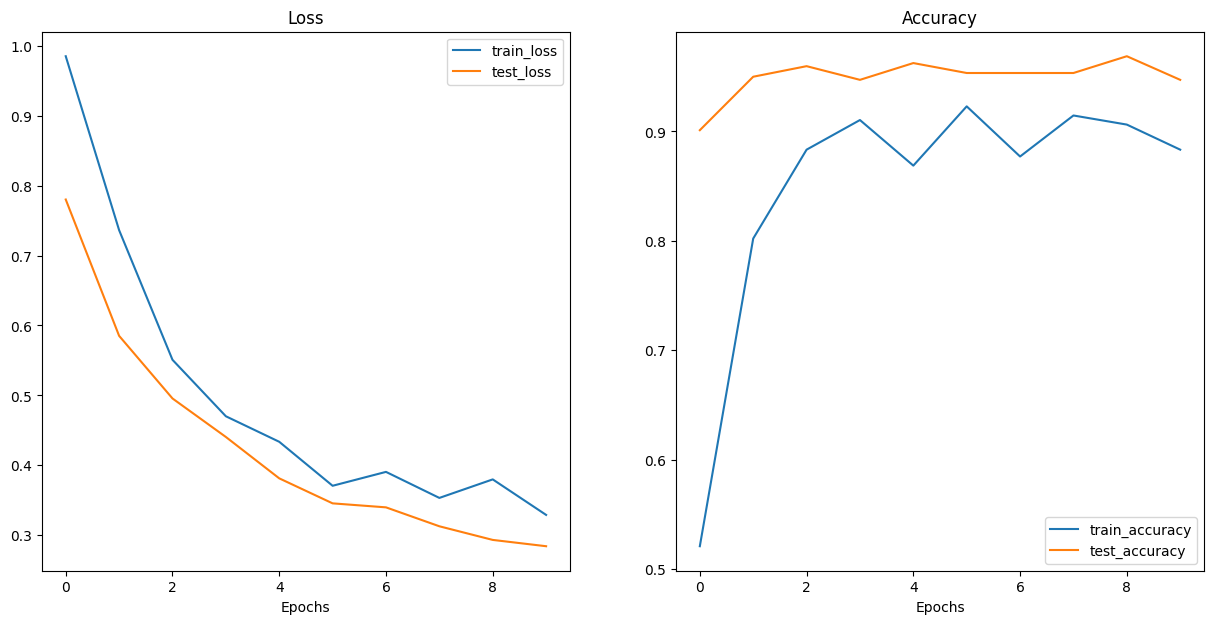

In [22]:
# plot the loss curve
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

In [23]:
# save effnetb2 to file
from going_modular.going_modular import utils

utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="pretrained_effnetb2_feature_extractor_pizza_sushi_steak_20_percent.pth")


[INFO] Saving model to: models/pretrained_effnetb2_feature_extractor_pizza_sushi_steak_20_percent.pth


In [24]:
# check the size of the model
from pathlib import Path

size = Path("models/pretrained_effnetb2_feature_extractor_pizza_sushi_steak_20_percent.pth").stat().st_size
print(f"model size: {size/(1024*1024):.2f} MB")

model size: 29.86 MB


In [25]:
# collect effnetb2 feature extractor model stats for later comparison
# number of parameters
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "nuber_of_parameter": effnetb2_total_params,
                  "model_size (MB)": 29.86}
effnetb2_stats

{'test_loss': 0.28441075384616854,
 'test_acc': 0.947159090909091,
 'nuber_of_parameter': 7705221,
 'model_size (MB)': 29.86}

### ViT feature extractor 

ViT: vision transformer

In [26]:
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [27]:
def create_vit_model(num_class:int = 3,
                     seed: int = 42):
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    for param in model.parameters():
        param.requires_grad=False

    torch.manual_seed(seed)
    model.heads = nn.Sequential(
        nn.Linear(in_features=768, out_features=num_class)
    )
    return model, transforms


In [28]:
vit, vit_transforms = create_vit_model()
vit, vit_transforms

(VisionTransformer(
   (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
   (encoder): Encoder(
     (dropout): Dropout(p=0.0, inplace=False)
     (layers): Sequential(
       (encoder_layer_0): EncoderBlock(
         (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
         (self_attention): MultiheadAttention(
           (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
         )
         (dropout): Dropout(p=0.0, inplace=False)
         (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
         (mlp): MLPBlock(
           (0): Linear(in_features=768, out_features=3072, bias=True)
           (1): GELU(approximate='none')
           (2): Dropout(p=0.0, inplace=False)
           (3): Linear(in_features=3072, out_features=768, bias=True)
           (4): Dropout(p=0.0, inplace=False)
         )
       )
       (encoder_layer_1): EncoderBlock(
         (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine

In [29]:
summary(vit,
        input_size=(1,3, 224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [30]:
# create dataloader
from going_modular.going_modular import data_setup

train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=vit_transforms,# <-- most important parameter
    batch_size=32)
len(train_dataloader_vit), len(test_dataloader_vit), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

In [31]:
# train

from going_modular.going_modular import engine

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=vit.parameters(), lr=1e-3)

torch.manual_seed(42)
torch.mps.manual_seed(42)

vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           epochs=10, 
                           device=device,
                           loss_fn=loss_fn,
                           optimizer=optimizer)

  0%|          | 0/10 [00:00<?, ?it/s]/Users/mikeqin/code/ml-training/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 10%|█         | 1/10 [01:38<14:50, 98.94s/it]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381


 20%|██        | 2/10 [03:15<13:02, 97.77s/it]

Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602


 30%|███       | 3/10 [04:52<11:20, 97.17s/it]

Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693


 40%|████      | 4/10 [06:29<09:41, 96.97s/it]

Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722


 50%|█████     | 5/10 [08:05<08:04, 96.86s/it]

Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784


 60%|██████    | 6/10 [09:42<06:27, 96.80s/it]

Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722


 70%|███████   | 7/10 [27:37<20:49, 416.60s/it]

Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784


 80%|████████  | 8/10 [53:35<26:00, 780.04s/it]

Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722


 90%|█████████ | 9/10 [55:12<09:26, 566.57s/it]

Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784


100%|██████████| 10/10 [56:49<00:00, 340.94s/it]

Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


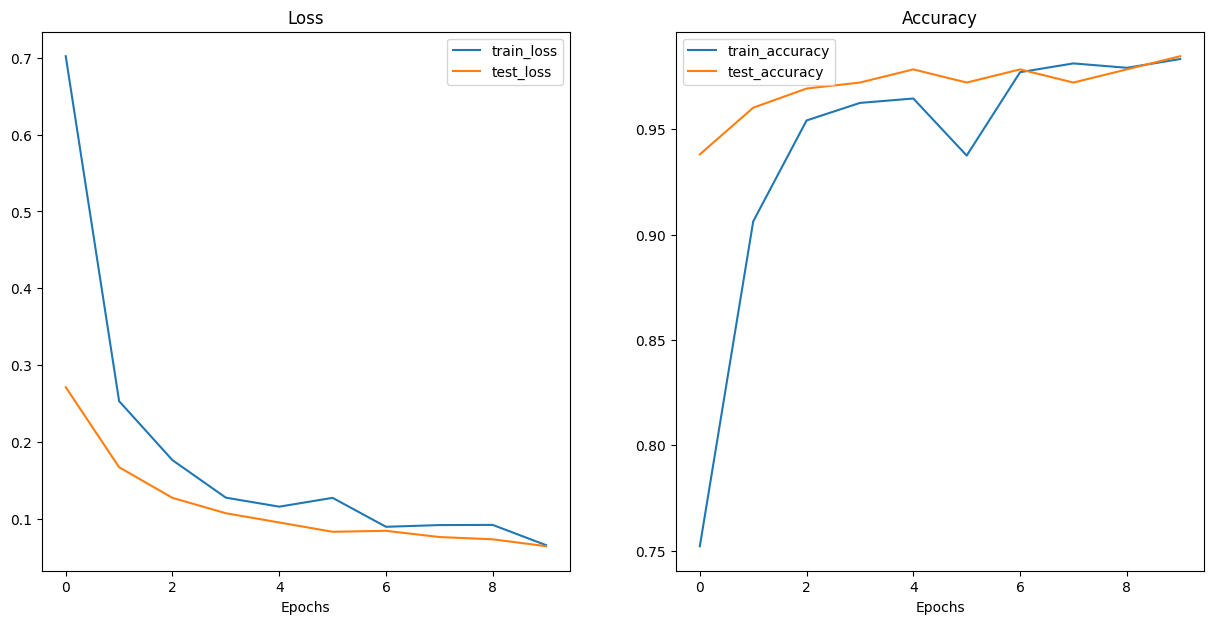

In [32]:
# plot loss curve
from helper_functions import plot_loss_curves
plot_loss_curves(vit_results)

In [33]:
utils.save_model(model=vit,
                 target_dir="models",
                 model_name="pretrained_vit_feature_extractor_pizza_sushi_steak_20_percent.pth")

[INFO] Saving model to: models/pretrained_vit_feature_extractor_pizza_sushi_steak_20_percent.pth


In [34]:
# check the size of the model
from pathlib import Path

size = Path("models/pretrained_vit_feature_extractor_pizza_sushi_steak_20_percent.pth").stat().st_size
print(f"model size: {size/(1024*1024):.2f} MB")

model size: 327.37 MB


In [35]:
vit_results["test_loss"]


[0.2713926985859871,
 0.16721019744873047,
 0.12734051682054998,
 0.1073614213615656,
 0.09531818283721805,
 0.0832292520441115,
 0.08448818549513817,
 0.07639315174892544,
 0.0734323781915009,
 0.06443448606878519]

In [36]:
# collect effnetb2 feature extractor model stats for later comparison
# number of parameters
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

vit_stats = {"test_loss": vit_results["test_loss"][-1],
                  "test_acc": vit_results["test_acc"][-1],
                  "nuber_of_parameter": vit_total_params,
                  "model_size (MB)": 327.37}
vit_stats

{'test_loss': 0.06443448606878519,
 'test_acc': 0.984659090909091,
 'nuber_of_parameter': 85800963,
 'model_size (MB)': 327.37}

In [37]:
# compare how fast for a prediction
# loop through test images, time how long each model takes to make a prediction on the image

from pathlib import Path

test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[PosixPath('data/pizza_steak_sushi_20_percent/test/steak/413497.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2246332.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2475366.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1982192.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2353677.jpg')]

In [38]:
from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm

def pred_and_store(paths: list[Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: list[str],
                   device: str) -> list[dict]:
    pred_list = []

    for path in tqdm(paths):
        pred_dict = {}
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        start_pred_store = timer()

        img = Image.open(path)

        transformed_image = transform(img).unsqueeze(0).to(device)

        model = model.to(device)
        model.eval()

        with torch.inference_mode():
            pred_logit = model(transformed_image)
            pred_prob = torch.softmax(pred_logit, dim=1)
            pred_label = torch.argmax(pred_prob, dim=1)

            # hard code to cpu here, python variable, class_names is a Python native list and live on CPU
            # pred_label is a tensor and live on MPS/GPU accelerator
            pred_class = class_names[pred_label.cpu()]
  
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class

            end_pred_store = timer()
            pred_dict["time_for_pred"] = round(end_pred_store-start_pred_store, 4)

        pred_dict["correct"] = class_name == pred_class
        pred_list.append(pred_dict)

    return pred_list

Predicate EffNetB2

In [39]:
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu")

100%|██████████| 150/150 [00:31<00:00,  4.74it/s]


In [40]:
effnetb2_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/413497.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.961,
  'pred_class': 'steak',
  'time_for_pred': 0.2906,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2246332.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9238,
  'pred_class': 'steak',
  'time_for_pred': 0.2032,
  'correct': True}]

In [41]:
len(effnetb2_test_pred_dicts)

150

In [42]:
import pandas as pd

effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()


,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/4...,steak,0.9610,steak,0.2906,True
1,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9238,steak,0.2032,True
2,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9242,steak,0.2598,True
3,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.8321,steak,0.2041,True
4,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.6745,steak,0.2011,True


In [43]:
effnetb2_test_pred_df["correct"].value_counts()

correct
True     142
False      8
Name: count, dtype: int64

In [44]:
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df["time_for_pred"].mean(), 4)
effnetb2_average_time_per_pred

np.float64(0.2105)

**Note** prediction times will vary much like the training times, depending on the hardware you're using... so generally the faster your compute (ex. CPU or GPU), the faster the prediction will happen

In [45]:
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred

Predicate ViT

In [46]:
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=vit,
                                          transform=vit_transforms,
                                          class_names=class_names,
                                          device="cpu")

100%|██████████| 150/150 [00:10<00:00, 14.50it/s]


In [47]:

vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()


,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/4...,steak,0.7962,steak,0.1755,True
1,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9981,steak,0.0775,True
2,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9959,steak,0.0709,True
3,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.9863,steak,0.0656,True
4,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9519,steak,0.0676,True


In [48]:
vit_test_pred_df["correct"].value_counts()

correct
True     148
False      2
Name: count, dtype: int64

In [49]:
vit_test_pred_df["pred_class"].value_counts()

pred_class
steak    57
pizza    47
sushi    46
Name: count, dtype: int64

In [50]:
vit_average_time_per_pred = round(vit_test_pred_df["time_for_pred"].mean(), 4)

In [51]:
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.06443448606878519,
 'test_acc': 0.984659090909091,
 'nuber_of_parameter': 85800963,
 'model_size (MB)': 327.37,
 'time_per_pred_cpu': np.float64(0.0688)}

In [56]:
# compare the model results
df = pd.DataFrame([effnetb2_stats, vit_stats])
df["model"] = ["EfficientNetB2", "ViT"]
df["test_acc"] = round(df["test_acc"] * 100, 2)
df

,test_loss,test_acc,nuber_of_parameter,model_size (MB),time_per_pred_cpu,model
0,0.284411,94.72,7705221,29.86,0.2105,EfficientNetB2
1,0.064434,98.47,85800963,327.37,0.0688,ViT


In [53]:
effnetb2_stats

{'test_loss': 0.28441075384616854,
 'test_acc': 0.947159090909091,
 'nuber_of_parameter': 7705221,
 'model_size (MB)': 29.86,
 'time_per_pred_cpu': np.float64(0.2105)}

In [54]:
vit_stats

{'test_loss': 0.06443448606878519,
 'test_acc': 0.984659090909091,
 'nuber_of_parameter': 85800963,
 'model_size (MB)': 327.37,
 'time_per_pred_cpu': np.float64(0.0688)}

In [57]:
df.set_index("model").loc['ViT']/df.set_index("model").loc["EfficientNetB2"]

test_loss              0.226554
test_acc               1.039590
nuber_of_parameter    11.135432
model_size (MB)       10.963496
time_per_pred_cpu      0.326841
dtype: float64

In [59]:
pd.DataFrame(data=(df.set_index("model").loc['ViT']/df.set_index("model").loc["EfficientNetB2"]),
             columns=['ViT to EffNetB2 ratios'])

,ViT to EffNetB2 ratios
test_loss,0.226554
test_acc,1.039590
nuber_of_parameter,11.135432
model_size (MB),10.963496
time_per_pred_cpu,0.326841


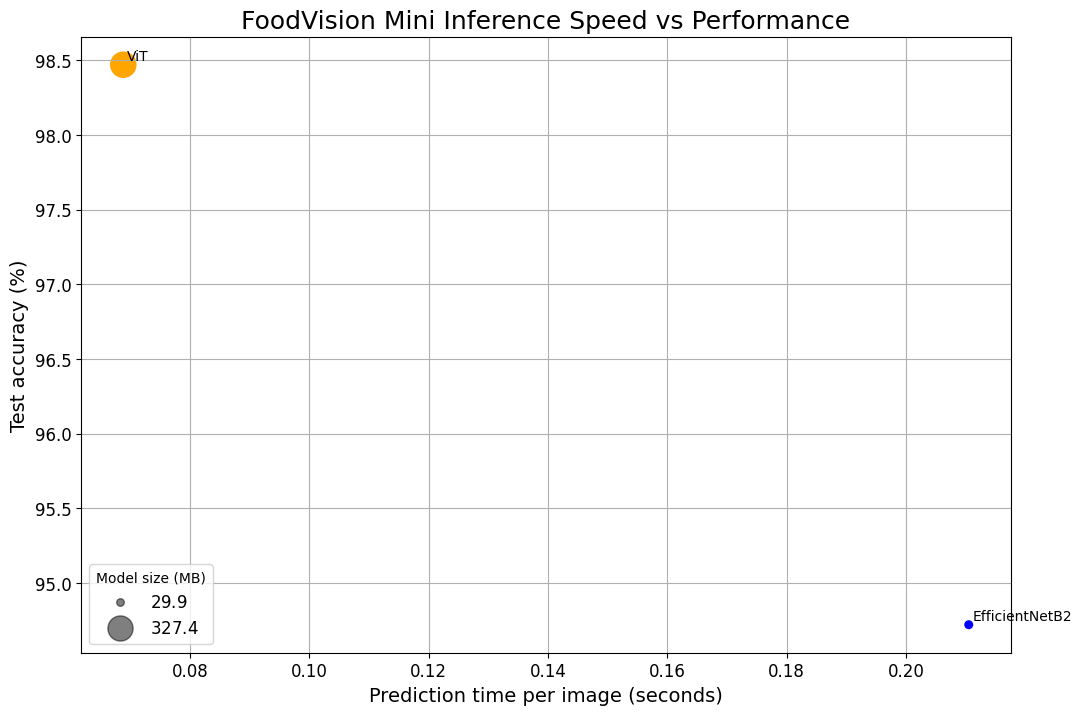

In [91]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,8))
scatter = ax.scatter(data=df, 
                     x="time_per_pred_cpu",
                     y="test_acc",
                     c=["blue", "orange"],
                     s="model_size (MB)") # <-- size in the same ratio as this column 

ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis="both", labelsize=12)
ax.grid(True)


for index, row in df.iterrows():
    ax.annotate(text=row["model"],
                xy=(row["time_per_pred_cpu"]+0.0006, row["test_acc"]+0.03))
    
handles,labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              loc="lower left",
                              title="Model size (MB)",
                              fontsize=12)

plt.savefig("foodvison_mini_inference_speed_vs_performance.png")

### Bring FoodVision to life

In [93]:
import gradio as gr
gr.__version__

'5.36.2'

In [92]:
# gradio is to map inputs -> function/model -> outputs
effnetb2 = effnetb2.to("cpu")
next(iter(effnetb2.parameters())).device


device(type='cpu')

In [33]:
# load the model in case the notebook restarted
# Create Food101 compatible EffNetB2 instance
loaded_effnetb2, loaded_effnetb2_transforms = create_effnetb2_model(num_classes=3)

# Load the saved model's state_dict()
loaded_effnetb2.load_state_dict(torch.load("models/pretrained_effnetb2_feature_extractor_pizza_sushi_steak_20_percent.pth"))

<All keys matched successfully>

In [37]:
# predict: image of food -> ML model -> outputs (food class label, prediction time)
# function name can be anything you like
from timeit import default_timer as timer

def predict(img) -> tuple[dict, float]: # <-- pay attention to the return tuple with a square branket
    pred_start = timer()
    
    img = loaded_effnetb2_transforms(img).unsqueeze(0) #effnetb2_transforms(img).unsqueeze(0) # add batch dimension to the 0th index

    loaded_effnetb2.eval()
    with torch.inference_mode():
        pred_probs = torch.softmax(loaded_effnetb2(img), dim=-1)
    
    pred_labels_and_prods = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    pred_end = timer()
    pred_time = round(pred_end - pred_start, 4)

    return pred_labels_and_prods, pred_time


In [38]:
import random
from PIL import Image

test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
random_image_path = random.sample(test_data_paths, k=1)[0]
random_image_path

image = Image.open(random_image_path)
pred_dict, pred_time = predict(img=image)
print(pred_dict)
print(pred_time)

{'pizza': 0.020717216655611992, 'steak': 0.964011549949646, 'sushi': 0.015271252952516079}
0.2348


In [40]:
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data/pizza_steak_sushi_20_percent/test/steak/48208.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/pizza/796922.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg']]

In [41]:
import gradio as gr

title="FoodVision Mini (Demo)🥩🍣🍕" #<-- Cmd + Ctrl + Space on macOS
# use MarkDown style to create description and article: text with its hyperlink:
description="An [EfficientNetB2 feature extractor](https://docs.pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.EfficientNet_B2_Weights)" 
article = "Created at [PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/#74-building-a-gradio-interface)"
demo = gr.Interface(fn=predict,  # map inputs to outputs
                    inputs=gr.Image(type='pil'),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # <-- only the top 3 classes will shown. For us we only have 3 so all of them
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article
                    )

demo.launch(debug=False, # <-- debug info
            share=True) # <-- generate a public url link

# click on the flag button on the display of the url, indicate that the image is not inferenced/predicted properly, and will added to the flagged folterd under gradio in our files

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://b64fdef3c5eae95e9c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


### Hugging Face Spaces
https://huggingface.co/docs/hub/spaces-overview

Under the hood, Spaces stores your code inside a git repository, just like the model and dataset repositories. Thanks to this, the same tools we use for all the other repositories on the Hub (git and git-lfs) also work for Spaces. Follow the same flow as in Getting Started with Repositories to add files to your Space. Each time a new commit is pushed, the Space will automatically rebuild and restart.


File structure

```
demos/
└── foodvision_mini/
    ├── 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
    ├── app.py
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
```

In [ ]:
# default app file is app.py that hugging face spaces will start from. You can chanage that in the readme file:
# for reference, see https://huggingface.co/spaces/mrdbourke/foodvision_mini/tree/main

In [7]:
!mkdir test

mkdir: test: File exists


In [6]:
#there is no space after %%
#folder has to exist first
%%writefile test/test.py

import torch
import torchvision
from torch import nn

UsageError: Line magic function `%%writefile` not found.
